## Pipeline on Amazon reviews

### About the Dataset

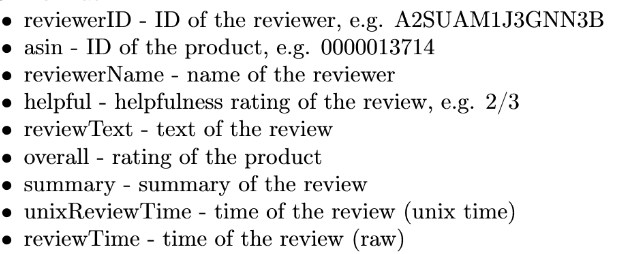

#### Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report , roc_auc_score , roc_curve

#### Import the  data 

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/imsreecharan/datasets_/refs/heads/master/amazon_reviews.csv')

In [3]:
df.head(2)

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,0528881469,"[0, 0]",5.0,We got this GPS for my husband who is an (OTR)...,"06 2, 2013",AO94DHGC771SJ,amazdnu,Gotta have GPS!,1.370131e+09
1,1,0528881469,"[12, 15]",1.0,"I'm a professional OTR truck driver, and I bou...","11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1.290643e+09


##### Shape

In [4]:
df.shape

(999, 10)

#### We have multiple features but here our main priority is how  of bag of words actually performed so for that reason we are kept only those column which is necessary for it
#### Like asin , reviewText , reviewerID , reviwerName , Summary

In [5]:
df = df[['asin' , 'overall' , 'reviewText'  , 'reviewerID', 'reviewerName' , 'summary']]

In [6]:
df.head(2)

,asin,overall,reviewText,reviewerID,reviewerName,summary
0,0528881469,5.0,We got this GPS for my husband who is an (OTR)...,AO94DHGC771SJ,amazdnu,Gotta have GPS!
1,0528881469,1.0,"I'm a professional OTR truck driver, and I bou...",AMO214LNFCEI4,Amazon Customer,Very Disappointed


In [7]:
df.shape

(999, 6)

#### Overall is dependent variable

### Preprocessing

##### 1.Handling missing values

In [8]:
df.isnull().sum()

asin            0
overall         0
reviewText      2
reviewerID      0
reviewerName    5
summary         0
dtype: int64

#### Insights : In reviewer feature contains 5 reviewernames  and in reviewText contains 2 reviewText are missing

In [9]:
len(df.isnull().sum()) / len(df)

0.006006006006006006

##### We don't have any issue to drop because its missing values % is  0.006006006006006006% of your total data. but dropping data is not best choice so we will handle those values by insert 'unknown' value there

In [10]:
df['reviewerName'].fillna('Unknown', inplace = True)

In [11]:
df.head(2)

,asin,overall,reviewText,reviewerID,reviewerName,summary
0,0528881469,5.0,We got this GPS for my husband who is an (OTR)...,AO94DHGC771SJ,amazdnu,Gotta have GPS!
1,0528881469,1.0,"I'm a professional OTR truck driver, and I bou...",AMO214LNFCEI4,Amazon Customer,Very Disappointed


In [12]:
df.isnull().sum()

asin            0
overall         0
reviewText      2
reviewerID      0
reviewerName    0
summary         0
dtype: int64

#### So I will only 2 records its not make big impact

In [13]:
df['reviewText'].isnull().sum() / len(df)

0.002002002002002002

#### Its just 0.002002002002002002%

In [14]:
df.dropna(subset = 'reviewText' ,axis = 0 , inplace = True)

In [15]:
df.head(2)

,asin,overall,reviewText,reviewerID,reviewerName,summary
0,0528881469,5.0,We got this GPS for my husband who is an (OTR)...,AO94DHGC771SJ,amazdnu,Gotta have GPS!
1,0528881469,1.0,"I'm a professional OTR truck driver, and I bou...",AMO214LNFCEI4,Amazon Customer,Very Disappointed


In [16]:
df.shape

(997, 6)

#### We noticed earlier we had shape (999 , 6) and now (997 , 6) means it depriacate two records

#### We had all data is characters so there is no any make sense to performs other preprocessing steps like scaling , capping outliers . We will performbow so there is not about encoding . for precaution we will check data balancing

In [17]:
df['overall'].value_counts()

5.0    580
4.0    188
3.0     94
1.0     87
2.0     48
Name: overall, dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 998
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   asin          997 non-null    object 
 1   overall       997 non-null    float64
 2   reviewText    997 non-null    object 
 3   reviewerID    997 non-null    object 
 4   reviewerName  997 non-null    object 
 5   summary       997 non-null    object 
dtypes: float64(1), object(5)
memory usage: 54.5+ KB


#### Here we will make 1.0 to 2.0 ratings as Negative Sentiment 
#### 3.0 rating as Neutral Sentiment
#### 4.0 to 5.0 as ratings as Positive Sentiment

In [19]:
 def ratings(rating):
        
        if rating == 3.0:
                
                return  "Neutral Sentiments"

            
        elif rating == 1.0 or rating == 2.0:
                
                return 'Negative Sentiments'
            
        elif rating == 4.0 or rating == 5.0:
                
                return  "Positive Sentiments"

#### apply is the function is takes another function as an argument and when use apply there is no need perform explicitely for loop because apply performs implicitely for loop on function.
#### basically it applies apply function on dataframe column and implicitely perform for loop on column means it take single value per iteration from overall column and give to ratings function as rating(parameter) and create one another column sentiments

In [20]:
df['sentiments'] = df['overall'].apply(ratings)

In [21]:
df.head(2)

,asin,overall,reviewText,reviewerID,reviewerName,summary,sentiments
0,0528881469,5.0,We got this GPS for my husband who is an (OTR)...,AO94DHGC771SJ,amazdnu,Gotta have GPS!,Positive Sentiments
1,0528881469,1.0,"I'm a professional OTR truck driver, and I bou...",AMO214LNFCEI4,Amazon Customer,Very Disappointed,Negative Sentiments


#### Now we drop the overall

In [22]:
df.drop('overall' , axis = 1 , inplace = True)

In [23]:
df.head(2)

,asin,reviewText,reviewerID,reviewerName,summary,sentiments
0,0528881469,We got this GPS for my husband who is an (OTR)...,AO94DHGC771SJ,amazdnu,Gotta have GPS!,Positive Sentiments
1,0528881469,"I'm a professional OTR truck driver, and I bou...",AMO214LNFCEI4,Amazon Customer,Very Disappointed,Negative Sentiments


#### Here we will drop asin (amazon standared Identification number).Its not significant because as we think no one gives his/ her review on basis of ProductID

In [24]:
df.drop('asin' , axis = 1 , inplace = True)

In [25]:
df.head(2)

,reviewText,reviewerID,reviewerName,summary,sentiments
0,We got this GPS for my husband who is an (OTR)...,AO94DHGC771SJ,amazdnu,Gotta have GPS!,Positive Sentiments
1,"I'm a professional OTR truck driver, and I bou...",AMO214LNFCEI4,Amazon Customer,Very Disappointed,Negative Sentiments


##### Check value counts of sentiments 

In [26]:
df['sentiments'].value_counts()

Positive Sentiments    768
Negative Sentiments    135
Neutral Sentiments      94
Name: sentiments, dtype: int64

### Insights : Data is Imbalance

## We will perform Data Balancing

#### Here our all data is text so we will not perform any oversampling or SMOTE . we will manually increase count of minority samples equal to majority samples

In [27]:
df['sentiments'].value_counts()

Positive Sentiments    768
Negative Sentiments    135
Neutral Sentiments      94
Name: sentiments, dtype: int64

#### We split the count of sentiments categories

In [28]:
positive_sentiments = df[df['sentiments'] == 'Positive Sentiments']
negative_sentiments = df[df['sentiments'] == 'Negative Sentiments']
neutral_sentiments =  df[df['sentiments'] == 'Neutral Sentiments']

In [29]:
positive_sentiments.head(2)

,reviewText,reviewerID,reviewerName,summary,sentiments
0,We got this GPS for my husband who is an (OTR)...,AO94DHGC771SJ,amazdnu,Gotta have GPS!,Positive Sentiments
5,I am using this with a Nook HD+. It works as d...,A2JXAZZI9PHK9Z,"Billy G. Noland ""Bill Noland""",HDMI Nook adapter cable,Positive Sentiments


In [30]:
negative_sentiments.head(2)

,reviewText,reviewerID,reviewerName,summary,sentiments
1,"I'm a professional OTR truck driver, and I bou...",AMO214LNFCEI4,Amazon Customer,Very Disappointed,Negative Sentiments
3,"Not going to write a long review, even thought...",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",Negative Sentiments


In [31]:
neutral_sentiments.head(2)

,reviewText,reviewerID,reviewerName,summary,sentiments
2,"Well, what can I say. I've had this unit in m...",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,Neutral Sentiments
13,"This is a good beefy 2 amp charger, but it cov...",A2QBZA4S1ROX9Q,Jake,It Works,Neutral Sentiments


#### Shape

In [32]:
print(positive_sentiments.shape)
print(negative_sentiments.shape) 
print(neutral_sentiments.shape)

(768, 5)
(135, 5)
(94, 5)


#### We will increase count of negtive sentiments and neutral sentiments equal to positive sentiments . we will increase duplications of records in this categories so it will equal to positive

#### Negative Sentiments

In [33]:
positive_sentiments.shape

(768, 5)

In [34]:
positive_sentiments.shape[0]

768

In [35]:
negative_sentiments = negative_sentiments.sample(positive_sentiments.shape[0] , replace = True)

In [36]:
negative_sentiments.shape

(768, 5)

#### neutral sentiments

In [37]:
neutral_sentiments = neutral_sentiments.sample(positive_sentiments.shape[0], replace = True)

In [38]:
neutral_sentiments.shape

(768, 5)

##### After Data Balancing by increase sampling method

In [39]:
print(positive_sentiments.shape)
print(negative_sentiments.shape)
print(neutral_sentiments.shape)

(768, 5)
(768, 5)
(768, 5)


In [40]:
df.shape

(997, 5)

#### Concate the ctegories of data

In [41]:
df= pd.concat([positive_sentiments , negative_sentiments , neutral_sentiments] , axis = 0 , ignore_index  = True)

In [42]:
df.head(2)

,reviewText,reviewerID,reviewerName,summary,sentiments
0,We got this GPS for my husband who is an (OTR)...,AO94DHGC771SJ,amazdnu,Gotta have GPS!,Positive Sentiments
1,I am using this with a Nook HD+. It works as d...,A2JXAZZI9PHK9Z,"Billy G. Noland ""Bill Noland""",HDMI Nook adapter cable,Positive Sentiments


In [43]:
df.shape

(2304, 5)

In [44]:
df['sentiments'].value_counts()

Positive Sentiments    768
Negative Sentiments    768
Neutral Sentiments     768
Name: sentiments, dtype: int64

### Encode the traget variable 

##### Here our target variable contains logical order like positive sentiments , negative sentiments , neutral sentiments so we will performal ordinal encoding

In [45]:
label = LabelEncoder()

In [46]:
df['sentiments'] = label.fit_transform(df['sentiments'])

In [47]:
df.head(2)

,reviewText,reviewerID,reviewerName,summary,sentiments
0,We got this GPS for my husband who is an (OTR)...,AO94DHGC771SJ,amazdnu,Gotta have GPS!,2
1,I am using this with a Nook HD+. It works as d...,A2JXAZZI9PHK9Z,"Billy G. Noland ""Bill Noland""",HDMI Nook adapter cable,2


In [48]:
df['sentiments'].value_counts()

2    768
0    768
1    768
Name: sentiments, dtype: int64

##### Negative as 0 , Neutral as 1 and positive as 2

##### Here our aim is make text to vector and then understand sentiment of reviews so we will drop the other variables which is not required because we want to analyse only reviewText


#### We will keep only reviewText

#### Split the data into independent and dependent variable

In [49]:
x = df.iloc[: , 0]
x

0       We got this GPS for my husband who is an (OTR)...
1       I am using this with a Nook HD+. It works as d...
2       This adaptor is real easy to setup and use rig...
3       This adapter easily connects my Nook HD 7&#34;...
4       This product really works great but I found th...
                              ...                        
2299    This microphone does what it states, but nothi...
2300    I'll make it simple. I loved my NOOK. I bring ...
2301    A decent color e-reader, but pretty much worth...
2302    Pro's: Easy to setup.  Supports many different...
2303    I like it but it does take a minute to come on...
Name: reviewText, Length: 2304, dtype: object

In [50]:
y = df.iloc[: , -1]
y.head(2)

0    2
1    2
Name: sentiments, dtype: int32

#### Split the data into train and test 

In [51]:
x_train, x_test , y_train , y_test = train_test_split(x , y , test_size = 0.25 , random_state = 2 ,stratify = y)

In [52]:
print(x_train.shape , x_test.shape , y_train.shape , y_test.shape)

(1728,) (576,) (1728,) (576,)


#### Here our aim is make text to vector and then understand sentiment of reviews so we will drop the other variables which is not required because we want to analyse only reviewtext

#### Now our all count of sentiments categories equal to positive sentiments

##### es, you're absolutely correct! Bag of Words (BoW) typically processes one text column at a time, because it is specifically designed to convert a single column of text data (usually representing a piece of written content like a review, comment, or any text) into numerical features.

##### Here's Why Bag of Words Focuses on One Column:
###### Textual Nature: BoW is a method for converting text into numerical features. It operates on text data in the form of sentences or documents (i.e., a collection of words). Each document (or row) gets represented by a vector that counts how many times each word (from the vocabulary) appears in the document.

##### Feature Vector Representation: Each document in your dataset is represented as a vector of word frequencies (or binary counts, depending on the variant of BoW). The vocabulary (set of all unique words across the dataset) becomes the set of features. If you have multiple text columns, you'd need to combine them into a single textual column to apply the Bag of Words approach.

### Now our Data is ready for model building

In [53]:
model = Pipeline(steps = [('Bag of Words' , CountVectorizer()) , ('GB' , GradientBoostingClassifier())])

In [54]:
model

Pipeline(steps=[('Bag of Words', CountVectorizer()),
                ('GB', GradientBoostingClassifier())])

##### pipeline is working in scenario where , First data come to countvectorizer (bag of words) it will make text to vector(numbers) and then build machine learning model (gb) on that data

#### Train the model

In [55]:
print(x_train.shape  , y_train.shape)

(1728,) (1728,)


In [56]:
model.fit(x_train , y_train)

Pipeline(steps=[('Bag of Words', CountVectorizer()),
                ('GB', GradientBoostingClassifier())])

##### Now we ready for prediction
#### Training Prediction

In [57]:
y_train_pred_gb = model.predict(x_train)

In [58]:
y_train_pred_gb

array([1, 0, 1, ..., 1, 2, 2])

##### Validation prediction / Testing Prediction

In [59]:
y_test_pred_gb = model.predict(x_test)

In [60]:
y_test_pred_gb

array([2, 2, 0, 0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 0, 0, 1, 0, 2, 2, 1, 1, 2,
       0, 2, 0, 1, 1, 0, 2, 2, 2, 2, 1, 0, 1, 2, 0, 0, 2, 2, 1, 1, 1, 0,
       1, 0, 2, 1, 2, 1, 0, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2,
       0, 2, 0, 2, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 0, 2, 0, 2, 0,
       0, 2, 1, 2, 0, 0, 0, 2, 0, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2,
       0, 1, 0, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 2, 1, 0,
       2, 1, 1, 1, 1, 2, 0, 0, 0, 2, 2, 1, 0, 0, 1, 2, 2, 2, 2, 2, 0, 2,
       1, 1, 0, 1, 0, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 0, 1, 0, 2,
       0, 0, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       2, 0, 0, 2, 1, 2, 0, 2, 0, 0, 2, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 2, 2, 2, 0, 0, 0, 2, 0, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 1, 2, 1,
       1, 2, 1, 2, 1, 1, 1, 0, 1, 0, 0, 1, 0, 2, 2, 1, 2, 2, 1, 1, 2, 0,
       2, 1, 0, 2, 0, 2, 1, 0, 0, 0, 2, 0, 2, 2, 1,

##### Performance metrics

##### Training accuracy and testing accuracy

In [61]:
training_accuracy_gb = accuracy_score(y_train , y_train_pred_gb)
testing_accuracy_gb = accuracy_score(y_test , y_test_pred_gb)

In [62]:
print(f'Training Accuracy of GB is {training_accuracy_gb} and Testing Accuracy is {testing_accuracy_gb}')

Training Accuracy of GB is 0.9809027777777778 and Testing Accuracy is 0.9253472222222222


#### Confusion matrix

In [63]:
print('Confusion matrix of of training model :')
print(confusion_matrix(y_train , y_train_pred_gb))
print('Confusion matrix of of testing model : ')
print(confusion_matrix(y_test , y_test_pred_gb))

Confusion matrix of of training model :
[[566   0  10]
 [  0 569   7]
 [  8   8 560]]
Confusion matrix of of testing model : 
[[189   0   3]
 [  0 186   6]
 [ 12  22 158]]


#### Classification Report

In [64]:
print('Classification Report of of training model :')
print(classification_report(y_train , y_train_pred_gb))
print('Classification Report of of testing model : ')
print(classification_report(y_test , y_test_pred_gb))

Classification Report of of training model :
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       576
           1       0.99      0.99      0.99       576
           2       0.97      0.97      0.97       576

    accuracy                           0.98      1728
   macro avg       0.98      0.98      0.98      1728
weighted avg       0.98      0.98      0.98      1728

Classification Report of of testing model : 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       192
           1       0.89      0.97      0.93       192
           2       0.95      0.82      0.88       192

    accuracy                           0.93       576
   macro avg       0.93      0.93      0.92       576
weighted avg       0.93      0.93      0.92       576



#### Here I check How model give respone of sentiments . Here I take some random reviews from test data and checkout sentiments which is predicted by model

##### For max with to read whole review

In [73]:
pd.set_option('display.max_colwidth', None)

In [79]:
print(x_test[:3])

1696                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               I have a ipod touch i

In [69]:
y_test_pred_gb[:3]

array([2, 2, 0])

#### Positive Sentiments

In [81]:
x_test.iloc[5]

"Awesome price and quality. Simple and easy to install and fully equipped for installation. If you need a swing arm mount for medium size tv this is one I'd recommend."

In [84]:
y_test_pred_gb[5]

2

#### Neutral sentiments

In [85]:
x_test.iloc[4]

"I'd never bought one of these, mainly due to the high prices in the retail stores.  I hadn't looked online much, and hadn't really needed a monitor mounting device until recently.This thing is well built, and it does the job.  It's not fancy but if you are just looking for an inexpensive way to hang a monitor (TV or PC) on the wall this will do the job.  It comes with a nice bag of heavy-duty hardware.  It is primarily designed for mounting TV sets, but you can get it to work with a PC monitor, as long as it has the VESA mounting.It mainly articulates side-to-side and in-and-out.  It'll pivot a bit up and down, but that's limited."

In [86]:
y_test_pred_gb[4]

1

#### Negative Sentiments

In [94]:
x_test.iloc[2]

"I am already a kindle owner and I love my kindle. The kindle does have some limitations, most especially in the handling of pdfs. The kindle does not annotate and curate highlighted text of pdf's you upload. This is where I found the Nook HD more useful, apart from the fact that it gives you full access to the Play Store. In handling big pdf's, the Nook HD is slow and the highlighting of scanned pdf's is not very smooth. I really tried to love the Nook but did not and so I did not use it beyond the first month. I will not recommend the Nook. If your goal is the android store, just get a nexus tablet and download B&N app. It is cheap and works much better than the Nook."

In [93]:
y_test_pred_gb[2]

0

#### Model Is Quite Good.It predict Quiet Accurate but actually my main purpose was here not sentiment analysis. i want to perform bag of words .